# Notebook evaluating metrics for particular node/edge configuration

In [1]:
# Imprt helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import netconf.netconf as nc

In [8]:
# Define variables
# Location variables
lat, lon, zoom = 33.893, 35.512, 14 # Map properties

# Building Footprints, damade assessments and interferogram file paths
buildingFile = "./data/beirutBuildingFootprints.geojson" # OSM data
assessmentFile = "./data/geopalData.csv" # GeoPal data
ifgFile = "./data/beirutPrePostExplosionIfg.tif" # SNAP output

# A priori damage beliefs (green, yellow, red decisions)
decisions = {'GREEN (inspected) أخضر (تم دراسته)': False, 'YELLOW (restricted use) أصفر (لا يصلح للسكن)': True, 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء': True}
beliefs = [0,0.9,1]

# Edge creation
adjacent, ifgValues, neighbours = True, True, 10

# Train/test split
testSplit, dmgThresh, stdTest, randomState = 0.3, 0.5, False, 42

# Classifications
targets = ['Undamaged', 'Damaged']

In [9]:
## Import Ground Data and combine
# Import footprints geojson
footprints = hf.import_OSM_fps(buildingFile)

# Import GeoPal assessments
assessments = hf.import_located_geopal_data(assessmentFile)

# Get joint geodataframe of building footprints with damage assessments
joint = hf.join_gdfs(footprints, assessments, column='decision')

# Display map of assessments upon which to draw Polygon for analysis
m1 = hf.create_map(lat, lon, zoom)
m1 = hf.plot_assessments(joint, m1)
m1, testPoly = hf.draw_polygon(joint, m1, stdTest)
m1

Map(center=[33.893, 35.512], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [10]:
# Import interferogram to dataframe
ifg, poly = hf.ifg_to_df(ifgFile, testPoly)

# Initialise beliefs for each pixel
initial = hf.init_beliefs(ifg, columns=['noDmg','dmg','ifg'])

# Split train/test set for located nodes
X_train, X_test, y_train, y_test = hf.train_test_split(joint, poly, column = 'decision')

# Create nodes
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, beliefs, column = 'decision', beliefColumns = ['noDmg', 'dmg'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, values=['ifg'] if ifgValues else False, neighbours=[neighbours])

Train/Test set stratification not possible due to less than 2 members from smallest class.


In [11]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True)

It	max{del(B)}	del(label)

0	3.78626e-01		19

1	1.67227e-01		37

2	8.58285e-02		5

3	4.29040e-02		8

4	2.18110e-02		2

5	1.10226e-02		1

6	5.53905e-03		0

7	2.76772e-03		0

8	1.37729e-03		0

9	6.82945e-04		0

10	3.37667e-04		0

11	1.66538e-04		0

12	8.19636e-05		0



              precision    recall  f1-score   support

   Undamaged       0.88      0.82      0.85        17
     Damaged       0.00      0.00      0.00         2

    accuracy                           0.74        19
   macro avg       0.44      0.41      0.42        19
weighted avg       0.78      0.74      0.76        19



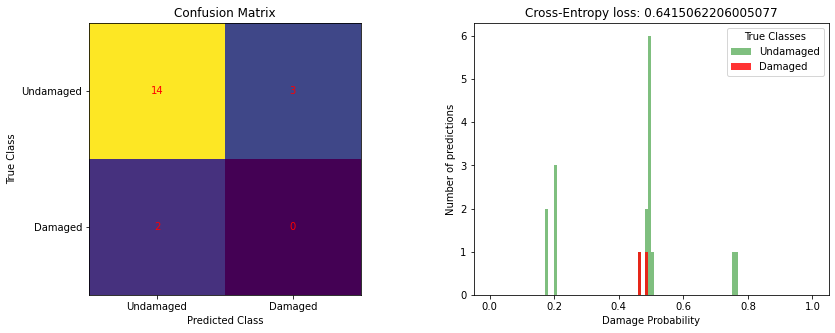

In [12]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='decision')

# Classification metrics
yp_clf = hf.class_metrics(y_true, y_pred, targets, threshold=dmgThresh)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, targets)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, targets)

hf.show_plot()